In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/water-quality-1.csv")

# Convert American-style timestamps to datetime (ignore hour/min)
df['Collect DateTime'] = pd.to_datetime(
    df['Collect DateTime'],
    format='%m/%d/%Y %I:%M:%S %p',
    errors='coerce'
).dt.date

In [3]:
# Derive temporal features
df['Year'] = pd.to_datetime(df['Collect DateTime']).dt.year
df['Month'] = pd.to_datetime(df['Collect DateTime']).dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

In [4]:
#Keep only relevant WQI parameters
relevant_params = [
    "pH  Field", "Temperature", "Dissolved Oxygen  Field", "Conductivity  Field",
    "Total Nitrogen", "Total Phosphorus"
]

df_filtered = df[df["Parameter"].isin(relevant_params)].copy()

print("Filtered dataset shape:", df_filtered.shape)
print("Unique parameters kept:", df_filtered["Parameter"].unique())

Filtered dataset shape: (44253, 28)
Unique parameters kept: ['Total Phosphorus' 'Temperature' 'Conductivity  Field' 'Total Nitrogen'
 'Dissolved Oxygen  Field' 'pH  Field']


In [5]:
df_wide = df_filtered.pivot_table(
    index=['Sample ID', 'Collect DateTime', 'Year', 'Month', 'Season'],
    columns='Parameter',
    values='Value',
    aggfunc='mean'
).reset_index()

#Simplify column names
df_wide.columns.name = None
df_wide.columns = [str(c).strip().replace("  ", " ") for c in df_wide.columns]

print("Wide dataset shape:", df_wide.shape)
print("Columns:", df_wide.columns.tolist())

Wide dataset shape: (38458, 11)
Columns: ['Sample ID', 'Collect DateTime', 'Year', 'Month', 'Season', 'Conductivity Field', 'Dissolved Oxygen Field', 'Temperature', 'Total Nitrogen', 'Total Phosphorus', 'pH Field']


In [40]:
cols_rename = {
    "pH Field": "pH",
    "Dissolved Oxygen Field": "DO",
    "Conductivity Field": "Conductivity",
    "Total Nitrogen": "Total_N",
    "Total Phosphorus": "Total_P",
}

df_small = df_wide.rename(columns=cols_rename).copy()

#Reorder columns neatly
df_small = df_small[[
    'pH', 'DO', 'Conductivity', 'Temperature', 'Total_N',
    'Total_P', 'Year', 'Month', 'Season'
]]

print(df_small.head())
print(df_small.shape)

   pH  DO  Conductivity  Temperature  Total_N  Total_P    Year  Month  Season
0 NaN NaN           NaN         15.1      NaN      NaN  2015.0    8.0  Summer
1 NaN NaN           NaN          8.8      NaN      NaN  2016.0    1.0  Winter
2 NaN NaN           NaN          NaN      NaN   0.0581  2016.0    1.0  Winter
3 NaN NaN           NaN          NaN    0.587      NaN  2016.0    2.0  Winter
4 NaN NaN           NaN         10.1      NaN      NaN  2016.0    2.0  Winter
(38458, 9)


In [41]:
# Missingness summary
missing_info = pd.DataFrame({
    "Missing Count": df_small.isna().sum(),
    "Missing %": (df_small.isna().sum() / len(df_small) * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

print(missing_info)

              Missing Count  Missing %
Total_N               34673      90.16
Total_P               33078      86.01
Conductivity          30799      80.08
DO                    30593      79.55
pH                    29725      77.29
Temperature           27898      72.54
Year                      0       0.00
Month                     0       0.00
Season                    0       0.00


In [42]:
numeric_cols = ['Temperature', 'pH', 'DO', 'Conductivity',
                'Total_N', 'Total_P',]

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_small[numeric_cols] = imputer.fit_transform(df_small[numeric_cols])

#PRE-1990 TEMPERTURE SPIKE
year_counts = df_small['Year'].value_counts().sort_index()
print(year_counts)

Year
1970.0      19
1971.0      27
1972.0      48
1973.0      35
1974.0      66
1975.0      42
1976.0      80
1977.0      73
1978.0      62
1979.0     148
1980.0     134
1981.0     165
1982.0     195
1983.0     217
1984.0     218
1985.0     252
1986.0     262
1987.0     210
1988.0     238
1989.0     180
1990.0     168
1991.0     213
1992.0     251
1993.0     559
1994.0     806
1995.0     926
1996.0    1100
1997.0     911
1998.0    1032
1999.0    1230
2000.0    1291
2001.0    1266
2002.0    1277
2003.0    1433
2004.0    1393
2005.0    1551
2006.0    1934
2007.0    2164
2008.0    2201
2009.0    1301
2010.0    1248
2011.0    1064
2012.0    1173
2013.0    1249
2014.0    1291
2015.0    1445
2016.0    1358
2017.0    1426
2018.0    1493
2019.0    1033
Name: count, dtype: int64


In [43]:
missing_info = pd.DataFrame({
    "Missing Count": df_small.isna().sum(),
    "Missing %": (df_small.isna().sum() / len(df_small) * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

print(missing_info)

              Missing Count  Missing %
pH                        0        0.0
DO                        0        0.0
Conductivity              0        0.0
Temperature               0        0.0
Total_N                   0        0.0
Total_P                   0        0.0
Year                      0        0.0
Month                     0        0.0
Season                    0        0.0


        count       mean       std  min     25%     50%      75%    max
Year                                                                   
1980.0  134.0  10.549940  2.739677  1.1  8.7995  10.390  12.4600  18.12
1981.0  165.0  11.290824  2.978826  5.5  9.2000  10.800  13.2800  21.80
1982.0  195.0  10.987897  3.501561  4.3  8.5040  10.400  13.0900  22.50
1983.0  217.0  11.104876  3.063263  4.9  8.9000  10.800  12.7000  21.10
1984.0  218.0  10.832688  3.367081  0.4  8.8955  10.450  12.3150  22.20
1985.0  252.0  10.695357  4.009322  2.0  8.3065  10.400  12.3910  24.10
1986.0  262.0  11.045534  3.597964  2.9  8.5400  10.400  12.4300  22.40
1987.0  210.0  11.036162  3.282414  4.0  8.5550  10.390  12.7750  22.44
1988.0  238.0  11.163092  3.061128  3.0  8.8940  11.019  12.9300  19.50
1989.0  180.0  11.047789  3.201137  2.1  9.0580  10.890  12.9550  22.50
1990.0  168.0  11.004976  3.194105  3.3  9.3800  11.000  12.7000  23.30
1991.0  213.0  10.276488  3.226448  2.0  8.2000  10.238  12.0440

<Axes: title={'center': 'Yearly Median Temperature'}, xlabel='Year'>

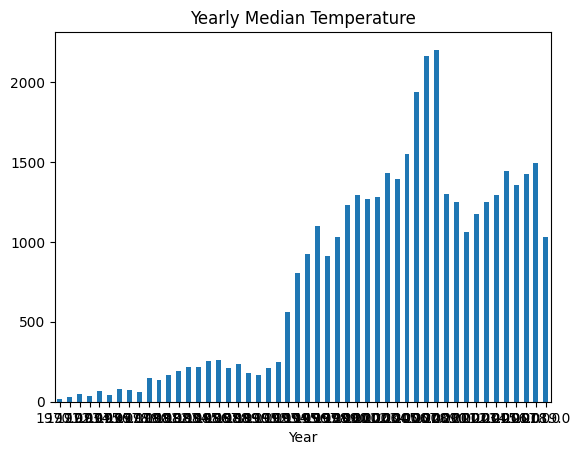

In [44]:
#Visualise data availability
year_counts.plot(kind='bar', title='Sample Count by Year')

#Check descriptive stats for Temperature by year
yearly_stats = df_small.groupby('Year')['Temperature'].describe()
print(yearly_stats.loc[1980:1995])  # focus on period of interest

#Quick visual of the spike
df_small.groupby('Year')['Temperature'].median().plot(title='Yearly Median Temperature')

In [45]:
def plot_boxplot(df, ft):
    df.boxplot(column=[ft])
    plt.grid(False)
    plt.show()
    #checking outliers

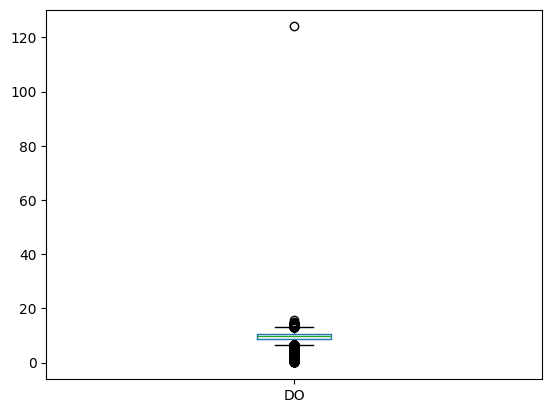

In [46]:
plot_boxplot(df_small, 'DO')

In [47]:
#Outlier removal
from sklearn.metrics import DistanceMetric as DM
from scipy.stats import f
from scipy.spatial import distance

In [51]:
#Select only numeric columns for covariance calculation
numeric_df_small = df_small.select_dtypes(include=np.number)

inv_cov = pd.DataFrame(np.linalg.pinv(numeric_df_small.cov().values), columns=numeric_df_small.cov().columns, index=numeric_df_small.cov().index)
x=numeric_df_small.values.tolist()
xbar=numeric_df_small.mean().tolist()

n=len(x)
k=len(x[0])

Hotvalue = f.ppf([0.95], n, k)*(n*k)/((n-k)+1)
print(Hotvalue)

[23.42586121]


In [52]:
for i in range(0,len(x)):

  df_small.loc[df_small.index==i,'hotelling']=(n*k)*distance.mahalanobis(x[i], xbar, inv_cov)**2/(k*(n-k))
  df_small.loc[df_small.index==i,'critical value']=Hotvalue


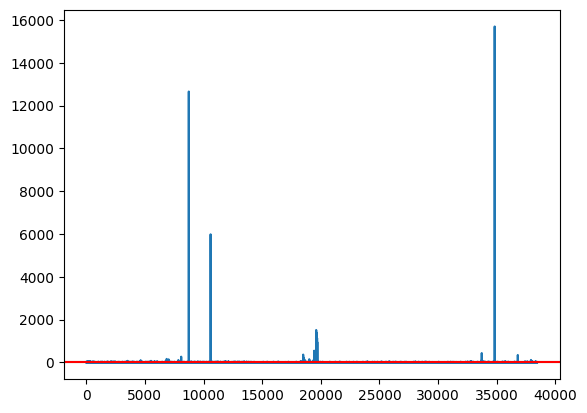

In [56]:
x=np.array(df_small.index.tolist())
y1=np.array(df_small['hotelling'])
f = plt.figure()

ax = f.add_subplot(111)


plt.plot(x, y1)
plt.axhline(y=df_small['hotelling'].mean())
plt.axhline(y=Hotvalue,color='r')

In [63]:
#removing outliers
df_clean = df_small[df_small['hotelling'] <= df_small['critical value'].iloc[0]].copy()
df_outliers = df_small[df_small['hotelling'] > df_small['critical value'].iloc[0]].copy()

print(df_clean.shape)
print(df_small.shape)

(37898, 11)
(38458, 11)


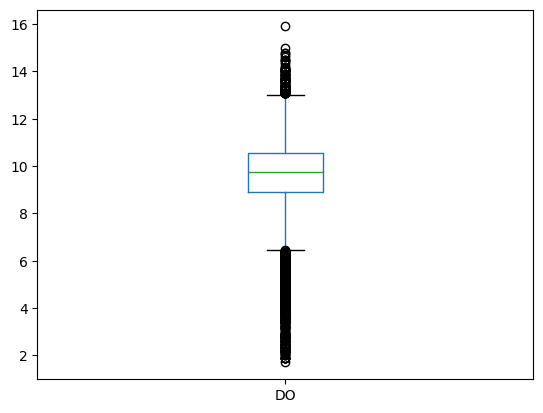

In [61]:
plot_boxplot(df_clean, 'DO')

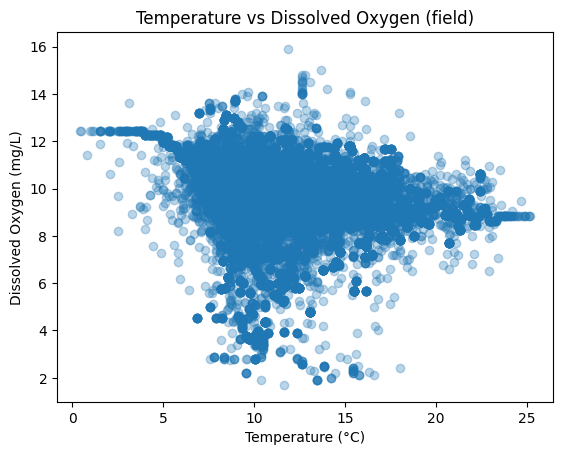

In [71]:
plt.scatter(df_clean["Temperature"], df_clean["DO"], alpha=0.3)
plt.title("Temperature vs Dissolved Oxygen (field)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

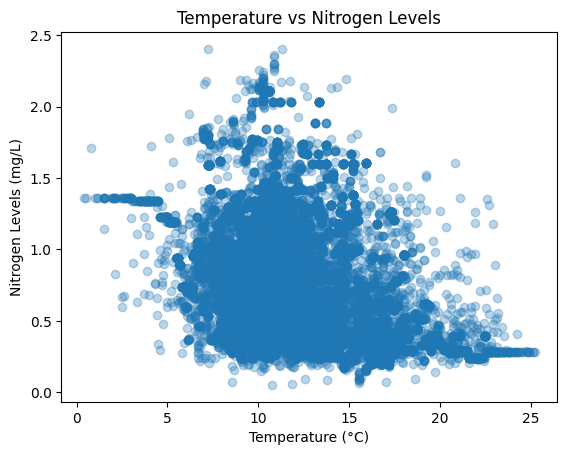

In [72]:
plt.scatter(df_clean["Temperature"], df_clean["Total_N"], alpha=0.3)
plt.title("Temperature vs Nitrogen Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Nitrogen Levels (mg/L)")
plt.show()

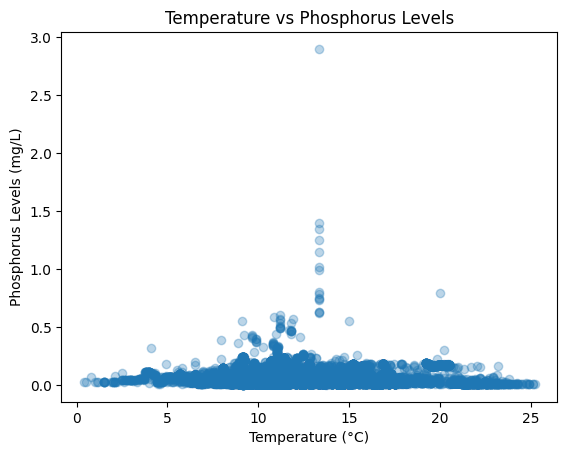

In [73]:
plt.scatter(df_clean["Temperature"], df_clean["Total_P"], alpha=0.3)
plt.title("Temperature vs Phosphorus Levels")
plt.xlabel("Temperature (°C)")
plt.ylabel("Phosphorus Levels (mg/L)")
plt.show()

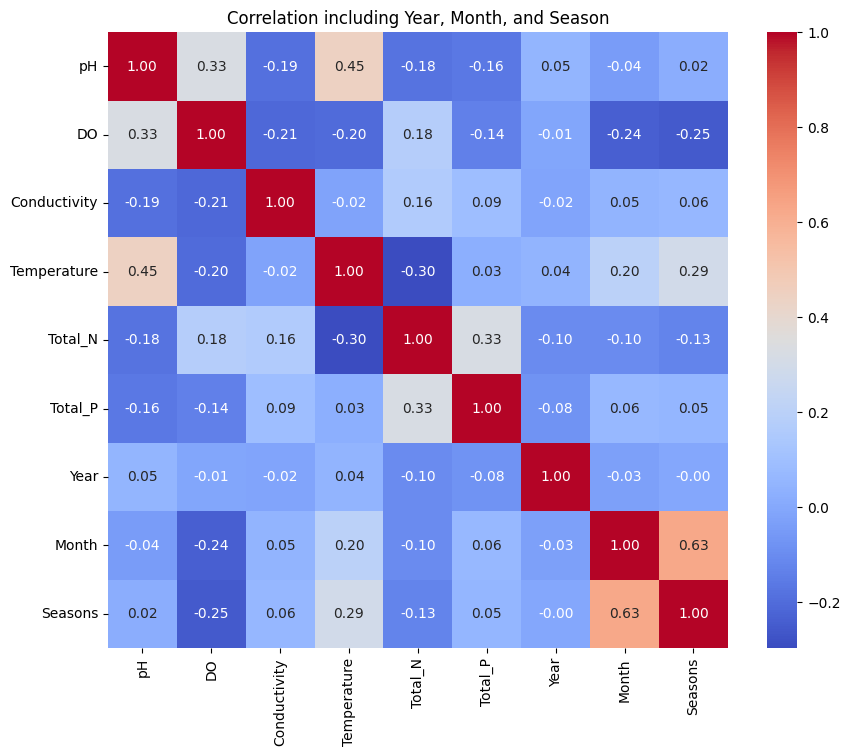

In [75]:
df_clean['Seasons'] = df_clean['Season'].map({
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Autumn': 4
})

# Select columns for correlation
cols_for_corr = [
    'pH', 'DO', 'Conductivity', 'Temperature',
    'Total_N', 'Total_P',
    'Year', 'Month', 'Seasons'
]

plt.figure(figsize=(10,8))
sns.heatmap(df_clean[cols_for_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation including Year, Month, and Season")
plt.show()
#year month and season were not numeric values so had to be encoded

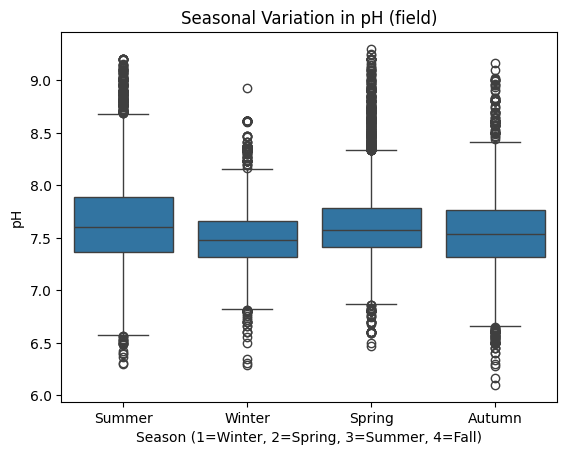

In [80]:
sns.boxplot(x="Season", y="pH", data=df_clean)
plt.title("Seasonal Variation in pH (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("pH")
plt.show()

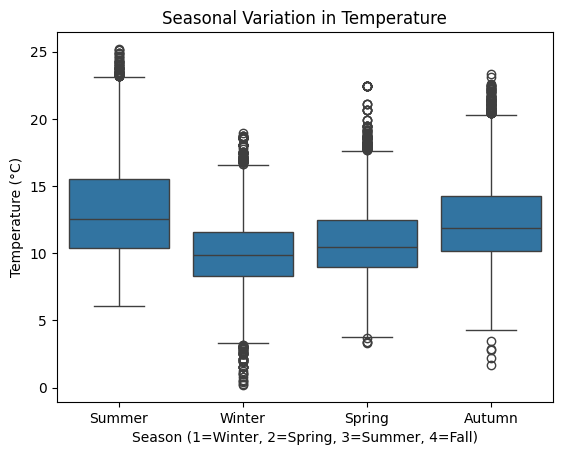

In [77]:
sns.boxplot(x="Season", y="Temperature", data=df_small)
plt.title("Seasonal Variation in Temperature")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Temperature (°C)")
plt.show()

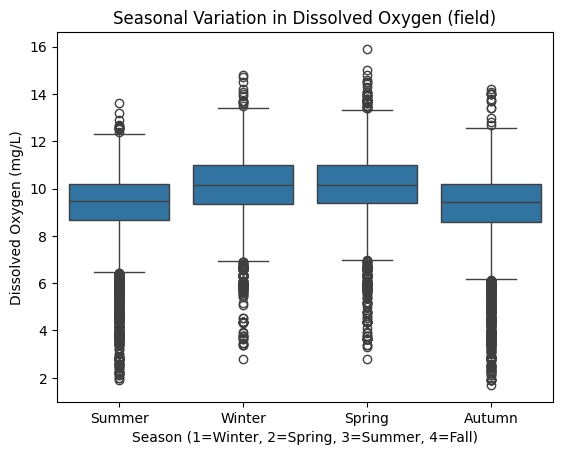

In [79]:
sns.boxplot(x="Season", y="DO", data=df_clean)
plt.title("Seasonal Variation in Dissolved Oxygen (field)")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.show()

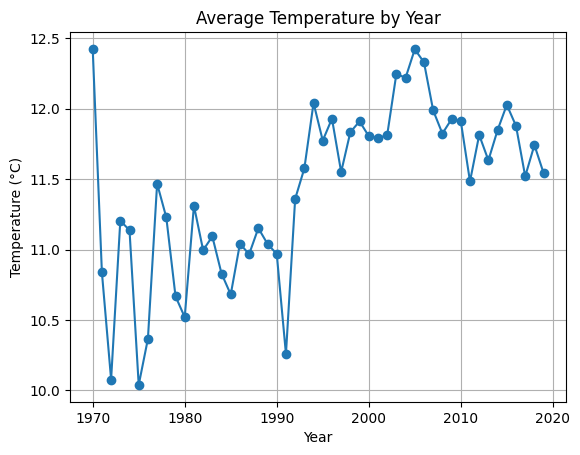

In [81]:
yearly_temp = df_clean.groupby("Year")["Temperature"].mean()

plt.plot(yearly_temp.index, yearly_temp.values, marker="o")
plt.title("Average Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

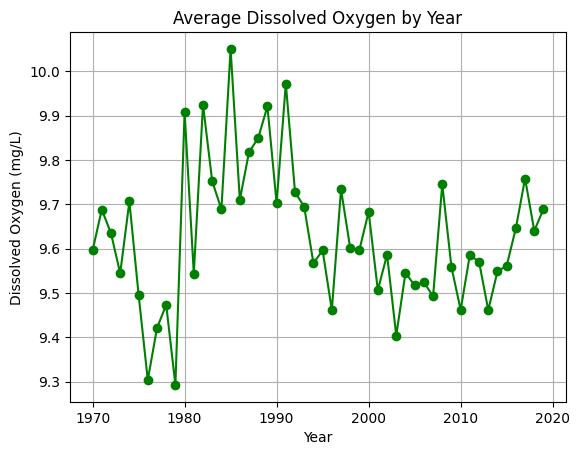

In [82]:
yearly_do = df_clean.groupby("Year")["DO"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="green")
plt.title("Average Dissolved Oxygen by Year")
plt.xlabel("Year")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(True)
plt.show()


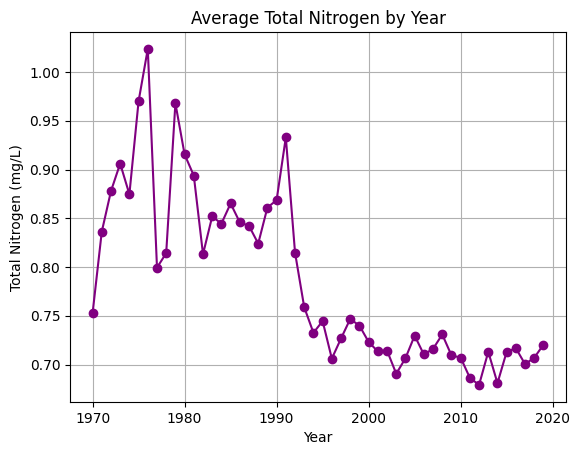

In [83]:
yearly_do = df_clean.groupby("Year")["Total_N"].mean()

plt.plot(yearly_do.index, yearly_do.values, marker="o", color="purple")
plt.title("Average Total Nitrogen by Year")
plt.xlabel("Year")
plt.ylabel("Total Nitrogen (mg/L)")
plt.grid(True)
plt.show()


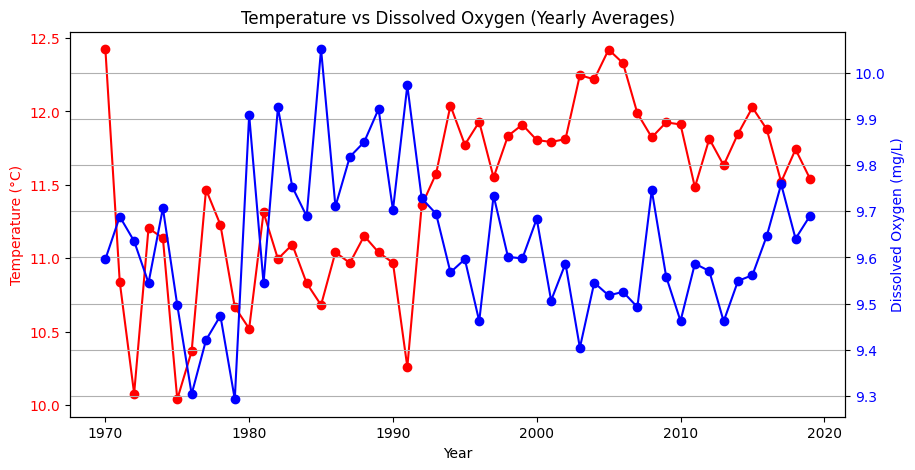

In [87]:
yearly = df_clean.groupby("Year")[["Temperature", "DO"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Temperature (left axis)
ax1.plot(yearly.index, yearly["Temperature"], color="red", marker="o", label="Temperature (°C)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Dissolved Oxygen (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["DO"], color="blue", marker="o", label="Dissolved Oxygen (mg/L)")
ax2.set_ylabel("Dissolved Oxygen (mg/L)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Temperature vs Dissolved Oxygen (Yearly Averages)")
plt.grid(True)
plt.show()

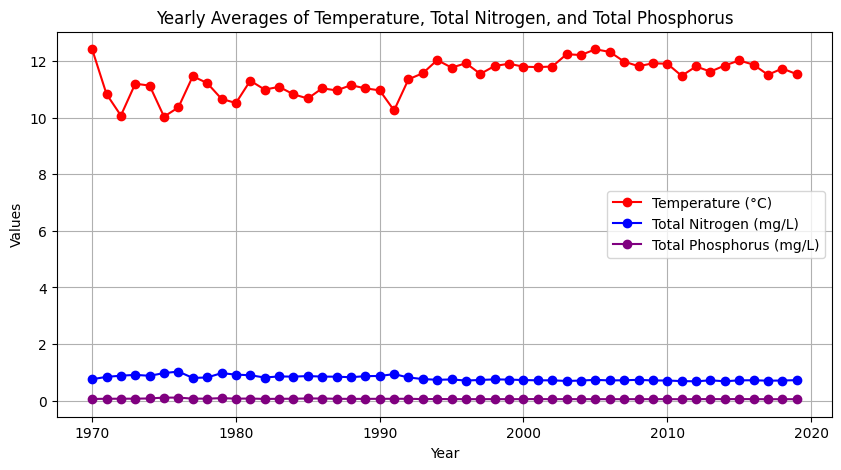

In [86]:
yearly = df_clean.groupby("Year")[["Temperature", "Total_N", "Total_P"]].mean()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly["Temperature"], marker="o", label="Temperature (°C)", color="red")
plt.plot(yearly.index, yearly["Total_N"], marker="o", label="Total Nitrogen (mg/L)", color="blue")
plt.plot(yearly.index, yearly["Total_P"], marker="o", label="Total Phosphorus (mg/L)", color="purple")

plt.title("Yearly Averages of Temperature, Total Nitrogen, and Total Phosphorus")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

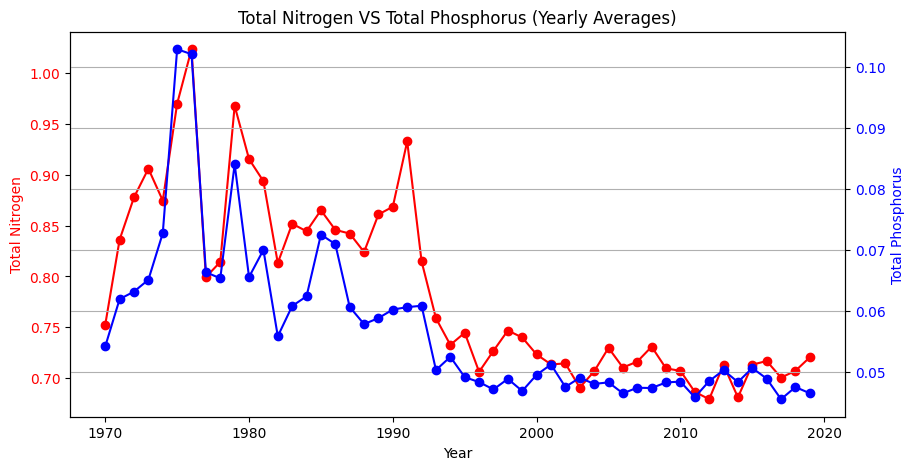

In [88]:
yearly = df_clean.groupby("Year")[["Total_N", "Total_P"]].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Nitrogen (left axis)
ax1.plot(yearly.index, yearly["Total_N"], color="red", marker="o", label="Total Nitrogen")
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Nitrogen", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Phosphorus (right axis)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["Total_P"], color="blue", marker="o", label="Total Phosphorus")
ax2.set_ylabel("Total Phosphorus", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("Total Nitrogen VS Total Phosphorus (Yearly Averages)")
plt.grid(True)
plt.show()

In [89]:
#MLR analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [90]:
target = 'Temperature'
predictors = [
    'pH', 'DO', 'Conductivity',
    'Total_N', 'Total_P']


In [91]:
X = sm.add_constant(df_clean[predictors])
y = df_clean[target]
mlr = sm.OLS(y, X).fit()
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     4410.
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:40:28   Log-Likelihood:                -90226.
No. Observations:               37898   AIC:                         1.805e+05
Df Residuals:                   37892   BIC:                         1.805e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.8276      0.297    -59.926   

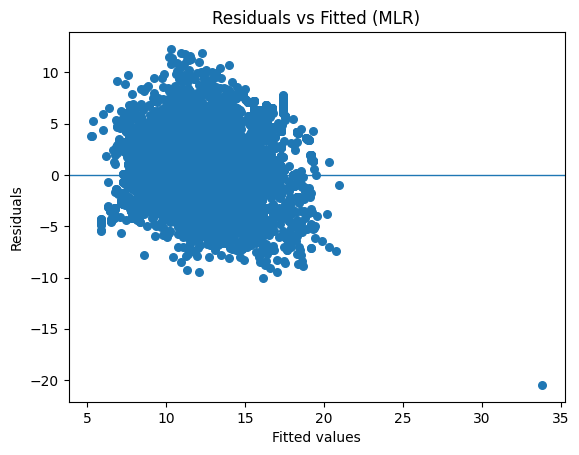

In [92]:
#residuals
fitted = mlr.fittedvalues
resid = mlr.resid

plt.figure()
plt.scatter(fitted, resid, s=30)
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (MLR)"); plt.show()

In [95]:
#VIF
X_vif = df_clean[predictors].values
vif_vals = [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
pd.DataFrame({"predictor": predictors, "VIF": np.round(vif_vals, 2)})

,predictor,VIF
0,pH,55.90
1,DO,53.57
2,Conductivity,3.51
3,Total_N,6.56
4,Total_P,2.39


In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_columns = ['Temperature', 'pH', 'DO', 'Conductivity', 'Total_N', 'Total_P']
X = df_small[pca_columns]

print("Data shape for PCA:", X.shape)
print("\nFirst few rows of data for PCA:")
print(X.head())

Data shape for PCA: (38458, 6)

First few rows of data for PCA:
   Temperature     pH      DO  Conductivity  Total_N  Total_P
0       15.100  8.014  10.360        138.46   1.1910  0.14080
1        8.800  7.336   7.020         97.08   1.0314  0.02820
2       10.314  7.828  11.300        181.00   1.0900  0.05810
3       11.500  7.690  10.260        110.82   0.5870  0.03252
4       10.100  7.366   9.332        100.02   0.4412  0.05748


In [97]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nData standardized - Mean: {X_scaled.mean():.2f}, Std: {X_scaled.std():.2f}")


Data standardized - Mean: -0.00, Std: 1.00


In [98]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.854366,0.760529,0.424198,1.107117,1.171773,0.005706
1,-1.479009,-0.550038,-0.088616,-0.498323,0.787407,0.862056
2,-0.145317,1.370434,0.157196,0.814881,0.071432,0.201882
3,0.382496,0.291891,-0.076132,-0.086364,-0.428304,0.009113
4,-0.318927,-0.306412,-0.257656,-0.725698,-0.699545,-0.060081


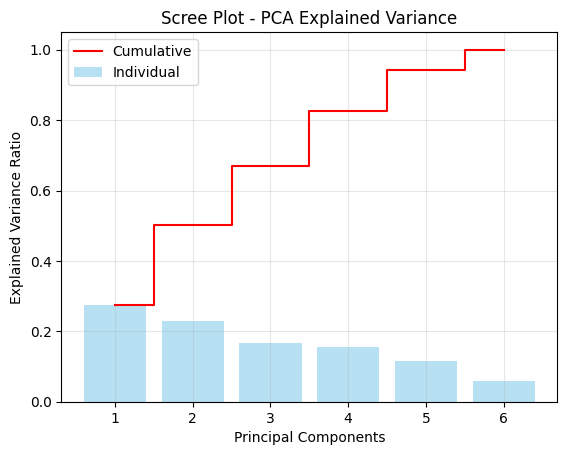

In [99]:
X_pca['Year'] = df_small['Year'].values
X_pca['Month'] = df_small['Month'].values
X_pca['Season'] = df_small['Season'].values

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='skyblue', label='Individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

In [100]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Temperature,0.577990,-0.345983,0.122765,0.201370,0.427159,-0.555101
pH,0.638204,0.251275,0.086564,0.304065,0.022987,0.655041
DO,0.155283,0.733726,-0.001368,0.196408,-0.371679,-0.510696
Conductivity,-0.239274,-0.363168,0.132573,0.800736,-0.389993,-0.003093
Total_N,-0.419621,0.383012,0.145454,0.373740,0.717246,0.044032
Total_P,-0.034301,0.014618,0.968866,-0.218081,-0.111019,0.004904
